In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
!pip install optuna

In [ ]:
# Random Forest

df = pd.read_csv('/content/drive/My Drive/Research/Drug Sens/dataset.csv')
X = df[['feature_ic50_t_pval', 'feature_delta_mean_ic50', 'feature_pos_ic50_var',
        'feature_neg_ic50_var', 'feature_pval' , 'fdr']]
y_log = df['log_ic50_mean_neg']

num_folds = 5

rmse_values = np.zeros(num_folds)
ic50_values = np.zeros_like(rmse_values)
r2_values = np.zeros_like(rmse_values)

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_log, y_test_log = y_log.iloc[train_index], y_log.iloc[test_index]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_log)

    y_pred_log = model.predict(X_test)

    y_pred = np.power(10, -y_pred_log)

    rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
    r2 = r2_score(y_test_log, y_pred_log)
    print(f"Fold {fold+1}: Root Mean Squared Error (RMSE): {rmse}")
    print(f"Fold {fold+1}: R^2: {r2}")

    rmse_values[fold] = rmse
    ic50_values = np.concatenate((ic50_values, y_pred))
    r2_values[fold] = r2

    fold += 1

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

mean_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print()
print("RMSE = {:.2f} +/- {:.2f}".format(mean_rmse, std_rmse))
print("R^2 = {:.2f} +/- {:.2f}".format(mean_r2, std_r2))

Fold 1: Root Mean Squared Error (RMSE): 1.9845361142529774
Fold 1: R^2: 0.2783671678977704
Fold 2: Root Mean Squared Error (RMSE): 1.8480726355499222
Fold 2: R^2: 0.14512804613739383
Fold 3: Root Mean Squared Error (RMSE): 2.2312761187957455
Fold 3: R^2: 0.1335146436172585
Fold 4: Root Mean Squared Error (RMSE): 1.9230484808108002
Fold 4: R^2: 0.22693411672706143
Fold 5: Root Mean Squared Error (RMSE): 1.8716807725732834
Fold 5: R^2: 0.2728184827345105

RMSE = 1.97 +/- 0.14
IC50 = 0.52 +/- 6.40
R^2 = 0.21 +/- 0.06


In [ ]:
# LightGBM

df = pd.read_csv('/content/drive/My Drive/Research/Drug Sens/dataset.csv')
X = df[['feature_ic50_t_pval', 'feature_delta_mean_ic50', 'feature_pos_ic50_var',
        'feature_neg_ic50_var', 'feature_pval' , 'fdr']]
y_log = df['log_ic50_mean_neg']
num_folds = 5

rmse_values = np.zeros(num_folds)
ic50_values = np.zeros_like(rmse_values)
r2_values = np.zeros_like(rmse_values)

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_log, y_test_log = y_log.iloc[train_index], y_log.iloc[test_index]

    train_data = lgb.Dataset(X_train, label=y_train_log)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 100,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=100)

    y_pred_log = model.predict(X_test)

    y_pred = np.power(10, -y_pred_log)

    rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
    r2 = r2_score(y_test_log, y_pred_log)

    rmse_values[fold] = rmse
    ic50_values = np.concatenate((ic50_values, y_pred))
    r2_values[fold] = r2

    fold += 1

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

mean_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print()
print("RMSE = {:.2f} +/- {:.2f}".format(mean_rmse, std_rmse))
print("R^2 = {:.2f} +/- {:.2f}".format(mean_r2, std_r2))

Fold 1: Root Mean Squared Error (RMSE): 1.9399998959622404
Fold 1: R^2: 0.31039296341212896
Fold 2: Root Mean Squared Error (RMSE): 1.8607974214996907
Fold 2: R^2: 0.13331518497633443
Fold 3: Root Mean Squared Error (RMSE): 2.2680605867145847
Fold 3: R^2: 0.10470966441020624
Fold 4: Root Mean Squared Error (RMSE): 1.8794281789561964
Fold 4: R^2: 0.2616071043736149
Fold 5: Root Mean Squared Error (RMSE): 1.8522445130470404
Fold 5: R^2: 0.28784273691718754

RMSE = 1.96 +/- 0.16
IC50 = 0.19 +/- 1.74
R^2 = 0.22 +/- 0.08


In [ ]:
# MLP

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/Research/Drug Sens/dataset.csv')
X = df[['feature_ic50_t_pval', 'feature_delta_mean_ic50', 'feature_pos_ic50_var', 'feature_neg_ic50_var', 'feature_pval', 'fdr']].values
y_log = df['log_ic50_mean_neg'].values

num_folds = 5

rmse_values = np.zeros(num_folds)
ic50_values = np.zeros_like(rmse_values)
r2_values = np.zeros_like(rmse_values)

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train_log, y_test_log = y_log[train_index], y_log[test_index]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train_scaled, y_train_log, epochs=100, batch_size=32, verbose=0)

    y_pred_log = model.predict(X_test_scaled)

    y_pred = np.power(10, -y_pred_log.flatten())

    rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
    r2 = r2_score(y_test_log, y_pred_log)
    print(f"Fold {fold+1}: Root Mean Squared Error (RMSE): {rmse}")
    print(f"Fold {fold+1}: R^2: {r2}")

    rmse_values[fold] = rmse
    ic50_values = np.concatenate((ic50_values, y_pred))
    r2_values[fold] = r2

    fold += 1

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

mean_ic50 = np.mean(ic50_values)
std_ic50 = np.std(ic50_values)

mean_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print()
print("RMSE = {:.2f} +/- {:.2f}".format(mean_rmse, std_rmse))
print("IC50 = {:.2f} +/- {:.2f}".format(mean_ic50, std_ic50))
print("R^2 = {:.2f} +/- {:.2f}".format(mean_r2, std_r2))


6/6 [==============================] - 1s 13ms/step
Fold 1: Root Mean Squared Error (RMSE): 2.011499751742164
Fold 1: R^2: 0.25862448690227335
6/6 [==============================] - 0s 2ms/step
Fold 2: Root Mean Squared Error (RMSE): 1.8031557341372964
Fold 2: R^2: 0.18617791578169907
6/6 [==============================] - 0s 3ms/step
Fold 3: Root Mean Squared Error (RMSE): 2.1607076899166735
Fold 3: R^2: 0.1874564855354076
6/6 [==============================] - 0s 2ms/step
Fold 4: Root Mean Squared Error (RMSE): 1.9135920618749847
Fold 4: R^2: 0.23451838797674218
6/6 [==============================] - 0s 2ms/step
Fold 5: Root Mean Squared Error (RMSE): 1.7697958552403714
Fold 5: R^2: 0.34983195387418964

RMSE = 1.93 +/- 0.14
IC50 = 0.84 +/- 14.77
R^2 = 0.24 +/- 0.06


In [ ]:
# LightGBM with Hyperparameter Tuning

df = pd.read_csv('/content/drive/My Drive/Research/Drug Sens/dataset.csv')
X = df[['feature_ic50_t_pval', 'feature_delta_mean_ic50', 'feature_pos_ic50_var',
        'feature_neg_ic50_var', 'feature_pval', 'fdr']]
y = df['log_ic50_mean_neg']

num_folds = 5

rmse_values = []
r2_values = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': trial.suggest_int('num_leaves', 10, 200),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'verbose': -1
        }

        train_data = lgb.Dataset(X_train, label=y_train)

        model = lgb.train(params, train_data, num_boost_round=100)

        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        return rmse

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", optuna.exceptions.TrialPruned)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=100)

    best_params = study.best_params

    model = lgb.train(best_params, lgb.Dataset(X_train, label=y_train), num_boost_round=100)

    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    rmse_values.append(rmse)
    r2_values.append(r2)

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

mean_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print()
print("RMSE = {:.2f} +/- {:.2f}".format(mean_rmse, std_rmse))
print("R^2 = {:.2f} +/- {:.2f}".format(mean_r2, std_r2))


[I 2023-06-01 08:28:39,363] A new study created in memory with name: no-name-1dcec30c-8619-4c2c-bd86-ed3fb68b8caf
[I 2023-06-01 08:28:39,758] Trial 0 finished with value: 2.1178630399430274 and parameters: {'num_leaves': 183, 'learning_rate': 0.013750377901982984, 'feature_fraction': 0.9372005249068044, 'bagging_fraction': 0.21376988702957242, 'bagging_freq': 6}. Best is trial 0 with value: 2.1178630399430274.
[I 2023-06-01 08:28:39,933] Trial 1 finished with value: 2.035845882437462 and parameters: {'num_leaves': 87, 'learning_rate': 0.09130509363436055, 'feature_fraction': 0.5943295440614602, 'bagging_fraction': 0.9269187614495782, 'bagging_freq': 6}. Best is trial 1 with value: 2.035845882437462.
[I 2023-06-01 08:28:40,115] Trial 2 finished with value: 2.029405474244934 and parameters: {'num_leaves': 130, 'learning_rate': 0.02508150873047837, 'feature_fraction': 0.4634316944807294, 'bagging_fraction': 0.5080641282801351, 'bagging_freq': 5}. Best is trial 2 with value: 2.029405474244

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 6
[LightGBM] [Info] Start training from score 3.195342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2023-06-01 08:28:55,337] Trial 2 finished with value: 1.8715873245403079 and parameters: {'num_leaves': 152, 'learning_rate': 0.014750845179988268, 'feature_fraction': 0.19805655868014976, 'bagging_fraction': 0.4207704173433764, 'bagging_freq': 9}. Best is trial 1 with value: 1.7947252083982757.
[I 2023-06-01 08:28:55,363] Trial 3 finished with value: 1.8237841574246045 and parameters: {'num_leaves': 68, 'learning_rate': 0.022740429897302863, 'feature_fraction': 0.4287607047126505, 'bagging_fraction': 0.1373499184806767, 'bagging_freq': 1}. Best is trial 1 with value: 1.7947252083982757.
[I 2023-06-01 08:28:55,429] Trial 4 finished with value: 1.8437210029132025 and parameters: {'num_leaves': 78, 'learning_rate': 0.03950284695664645, 'feature_fraction': 0.14167272200944075, 'bagging_fraction': 0.7021214906010423, 'bagging_freq': 2}. Best is trial 1 with value: 1.7947252083982757.
[I 2023-06-01 08:28:55,468] Trial 5 finished with value: 1.8700069674086495 and parameters: {'num_leaves

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 6
[LightGBM] [Info] Start training from score 3.164955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2023-06-01 08:29:10,651] Trial 2 finished with value: 2.232815152497166 and parameters: {'num_leaves': 51, 'learning_rate': 0.03902103269941749, 'feature_fraction': 0.8532708482072252, 'bagging_fraction': 0.6421673071063797, 'bagging_freq': 8}. Best is trial 2 with value: 2.232815152497166.
[I 2023-06-01 08:29:10,715] Trial 3 finished with value: 2.2145947346722394 and parameters: {'num_leaves': 34, 'learning_rate': 0.018867189769652903, 'feature_fraction': 0.8897421785765844, 'bagging_fraction': 0.8291318237909582, 'bagging_freq': 7}. Best is trial 3 with value: 2.2145947346722394.
[I 2023-06-01 08:29:10,744] Trial 4 finished with value: 2.243214389933947 and parameters: {'num_leaves': 150, 'learning_rate': 0.09023038464134413, 'feature_fraction': 0.8549818601794303, 'bagging_fraction': 0.20744812714817396, 'bagging_freq': 7}. Best is trial 3 with value: 2.2145947346722394.
[I 2023-06-01 08:29:10,787] Trial 5 finished with value: 2.4047562351982257 and parameters: {'num_leaves': 12

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 6
[LightGBM] [Info] Start training from score 3.201653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2023-06-01 08:29:20,528] Trial 3 finished with value: 1.9041819307360563 and parameters: {'num_leaves': 159, 'learning_rate': 0.029527696040539553, 'feature_fraction': 0.47070453338946283, 'bagging_fraction': 0.468426159759913, 'bagging_freq': 8}. Best is trial 3 with value: 1.9041819307360563.
[I 2023-06-01 08:29:20,573] Trial 4 finished with value: 1.8933729302448525 and parameters: {'num_leaves': 41, 'learning_rate': 0.0480550211269237, 'feature_fraction': 0.6800891349743814, 'bagging_fraction': 0.41916592066538505, 'bagging_freq': 3}. Best is trial 4 with value: 1.8933729302448525.
[I 2023-06-01 08:29:20,630] Trial 5 finished with value: 2.0768760454062765 and parameters: {'num_leaves': 190, 'learning_rate': 0.012851068410137145, 'feature_fraction': 0.10630133372052593, 'bagging_fraction': 0.9348059886251562, 'bagging_freq': 4}. Best is trial 4 with value: 1.8933729302448525.
[I 2023-06-01 08:29:20,679] Trial 6 finished with value: 1.8886597803560867 and parameters: {'num_leaves

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 6
[LightGBM] [Info] Start training from score 3.246187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2023-06-01 08:29:33,255] A new study created in memory with name: no-name-065b084a-4a11-4d32-ad52-101570c0b66b
[I 2023-06-01 08:29:33,363] Trial 0 finished with value: 1.985494843985066 and parameters: {'num_leaves': 121, 'learning_rate': 0.030232370412593215, 'feature_fraction': 0.1625133369977065, 'bagging_fraction': 0.4731299538869643, 'bagging_freq': 4}. Best is trial 0 with value: 1.985494843985066.
[I 2023-06-01 08:29:33,613] Trial 1 finished with value: 1.8440129640706433 and parameters: {'num_leaves': 131, 'learning_rate': 0.0512596035605917, 'feature_fraction': 0.8329798411693563, 'bagging_fraction': 0.8623451582371713, 'bagging_freq': 7}. Best is trial 1 with value: 1.8440129640706433.
[I 2023-06-01 08:29:33,689] Trial 2 finished with value: 1.888037125107674 and parameters: {'num_leaves': 98, 'learning_rate': 0.06885433708593744, 'feature_fraction': 0.3559278554861688, 'bagging_fraction': 0.5094785410503477, 'bagging_freq': 1}. Best is trial 1 with value: 1.84401296407064

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 6
[LightGBM] [Info] Start training from score 3.152942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
# Random Forest with Hyperparameter Tuning

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    model = RandomForestRegressor(random_state=42, **params)

    rmse_values = []
    r2_values = []

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_log, y_test_log = y_log.iloc[train_index], y_log.iloc[test_index]

        model.fit(X_train, y_train_log)

        y_pred_log = model.predict(X_test)

        y_pred = np.power(10, -y_pred_log)

        rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
        r2 = r2_score(y_test_log, y_pred_log)

        rmse_values.append(rmse)
        r2_values.append(r2)

    return np.mean(rmse_values)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = RandomForestRegressor(random_state=42, **best_params)

rmse_values = []
r2_values = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_log, y_test_log = y_log.iloc[train_index], y_log.iloc[test_index]

    best_model.fit(X_train, y_train_log)

    y_pred_log = best_model.predict(X_test)

    y_pred = np.power(10, -y_pred_log)

    rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
    r2 = r2_score(y_test_log, y_pred_log)

    rmse_values.append(rmse)
    r2_values.append(r2)

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

mean_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print()
print("RMSE = {:.2f} +/- {:.2f}".format(mean_rmse, std_rmse))
print("R^2 = {:.2f} +/- {:.2f}".format(mean_r2, std_r2))


[I 2023-06-01 08:39:56,870] A new study created in memory with name: no-name-e50cf7c2-b6bd-4a4b-8461-740b69c215d5
[I 2023-06-01 08:39:59,181] Trial 0 finished with value: 1.9489089198646596 and parameters: {'n_estimators': 176, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.9489089198646596.
[I 2023-06-01 08:40:00,989] Trial 1 finished with value: 1.9414288640269688 and parameters: {'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.9414288640269688.
[I 2023-06-01 08:40:02,740] Trial 2 finished with value: 1.9413818946359789 and parameters: {'n_estimators': 179, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 1.9413818946359789.
[I 2023-06-01 08:40:04,224] Trial 3 finished with value: 1.9412035048363787 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_s


Best hyperparameters: {'n_estimators': 186, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
RMSE = 1.93 +/- 0.18
R^2 = 0.25 +/- 0.06


In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# MLP with Hyperparameter Tuning

def objective(trial):
    units = trial.suggest_int('units', 16, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    rmse_values = []
    r2_values = []

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train_log, y_test_log = y_log[train_index], y_log[test_index]

        model = Sequential()
        model.add(Dense(units, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(units // 2, activation='relu'))
        model.add(Dense(1, activation='linear'))

        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)

        model.fit(X_train, y_train_log, epochs=20, batch_size=32, verbose=0)

        y_pred_log = model.predict(X_test)

        y_pred = np.power(10, -y_pred_log.flatten())

        rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
        r2 = r2_score(y_test_log, y_pred_log)

        rmse_values.append(rmse)
        r2_values.append(r2)

    return np.mean(rmse_values)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

best_params = study.best_params
best_model = Sequential()
best_model.add(Dense(best_params['units'], input_dim=X.shape[1], activation='relu'))
best_model.add(Dense(best_params['units'] // 2, activation='relu'))
best_model.add(Dense(1, activation='linear'))

best_optimizer = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(loss='mean_squared_error', optimizer=best_optimizer)

rmse_values = []
r2_values = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train_log, y_test_log = y_log[train_index], y_log[test_index]

    best_model.fit(X_train, y_train_log, epochs=20, batch_size=32, verbose=0)

    y_pred_log = best_model.predict(X_test)

    y_pred = np.power(10, -y_pred_log.flatten())

    rmse = mean_squared_error(y_test_log, y_pred_log, squared=False)
    r2 = r2_score(y_test_log, y_pred_log)

    rmse_values.append(rmse)
    r2_values.append(r2)

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

mean_ic50 = np.mean(ic50_values)
std_ic50 = np.std(ic50_values)

mean_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print()
print("Best hyperparameters:", best_params)
print("RMSE = {:.2f} +/- {:.2f}".format(mean_rmse, std_rmse))
print("IC50 = {:.2f} +/- {:.2f}".format(mean_ic50, std_ic50))
print("R^2 = {:.2f} +/- {:.2f}".format(mean_r2, std_r2))


[I 2023-06-01 09:44:10,786] A new study created in memory with name: no-name-f1b78e77-18ed-4dd7-9570-9ec4c6c6ccda


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:44:24,302] Trial 0 finished with value: 2.020281306450946 and parameters: {'units': 40, 'learning_rate': 0.0015650869497195778}. Best is trial 0 with value: 2.020281306450946.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:44:35,683] Trial 1 finished with value: 2.413475965987325 and parameters: {'units': 106, 'learning_rate': 0.00013060722325536247}. Best is trial 0 with value: 2.020281306450946.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:44:47,134] Trial 2 finished with value: 2.022200062899429 and parameters: {'units': 98, 'learning_rate': 0.0008941300237684373}. Best is trial 0 with value: 2.020281306450946.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:44:59,497] Trial 3 finished with value: 1.9519685831130864 and parameters: {'units': 100, 'learning_rate': 0.009421866871628291}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:45:10,508] Trial 4 finished with value: 2.0463527559536314 and parameters: {'units': 41, 'learning_rate': 0.0015929673301145982}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:45:21,322] Trial 5 finished with value: 1.9663419381146283 and parameters: {'units': 71, 'learning_rate': 0.0029808851467133623}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:45:32,999] Trial 6 finished with value: 2.02342180424981 and parameters: {'units': 17, 'learning_rate': 0.00797845731930086}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:45:45,532] Trial 7 finished with value: 1.9542602120859862 and parameters: {'units': 112, 'learning_rate': 0.001815623136988968}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:45:55,744] Trial 8 finished with value: 2.061109706631626 and parameters: {'units': 72, 'learning_rate': 0.0008225914703078834}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:46:05,864] Trial 9 finished with value: 1.9822455159394998 and parameters: {'units': 99, 'learning_rate': 0.0009957523056467693}. Best is trial 3 with value: 1.9519685831130864.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:46:18,220] Trial 10 finished with value: 1.9509213321351713 and parameters: {'units': 124, 'learning_rate': 0.0078813462111995}. Best is trial 10 with value: 1.9509213321351713.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:46:31,282] Trial 11 finished with value: 1.9466030081084391 and parameters: {'units': 119, 'learning_rate': 0.00893070914136971}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:46:42,767] Trial 12 finished with value: 1.981547270787397 and parameters: {'units': 126, 'learning_rate': 0.0057382564339413245}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:46:54,945] Trial 13 finished with value: 1.9534147253363827 and parameters: {'units': 128, 'learning_rate': 0.005386848689364837}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:47:05,434] Trial 14 finished with value: 1.9883887785745284 and parameters: {'units': 87, 'learning_rate': 0.009878136047846995}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:47:16,937] Trial 15 finished with value: 1.971869022035046 and parameters: {'units': 117, 'learning_rate': 0.004005269840780167}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:47:28,415] Trial 16 finished with value: 1.9652844481550633 and parameters: {'units': 86, 'learning_rate': 0.0035126807692808125}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:47:39,763] Trial 17 finished with value: 1.9529684217192371 and parameters: {'units': 62, 'learning_rate': 0.005946272049488305}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:47:50,511] Trial 18 finished with value: 1.9619294284919906 and parameters: {'units': 119, 'learning_rate': 0.009276176183476186}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:48:02,765] Trial 19 finished with value: 1.9500652761202115 and parameters: {'units': 88, 'learning_rate': 0.0028603533243031962}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:48:13,072] Trial 20 finished with value: 1.961064396817212 and parameters: {'units': 56, 'learning_rate': 0.0028606069182491828}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:48:24,815] Trial 21 finished with value: 1.9806443350336618 and parameters: {'units': 85, 'learning_rate': 0.005523340820833125}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:48:35,935] Trial 22 finished with value: 1.974793404503653 and parameters: {'units': 111, 'learning_rate': 0.004310651640090161}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:48:48,582] Trial 23 finished with value: 1.9516134398149518 and parameters: {'units': 128, 'learning_rate': 0.006549942555878799}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:49:00,151] Trial 24 finished with value: 1.9613022613269977 and parameters: {'units': 91, 'learning_rate': 0.007575095404457192}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:49:10,601] Trial 25 finished with value: 1.9549635076815144 and parameters: {'units': 120, 'learning_rate': 0.004473114314908658}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:49:20,977] Trial 26 finished with value: 1.956136473217159 and parameters: {'units': 107, 'learning_rate': 0.0028326184605035674}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:49:33,220] Trial 27 finished with value: 1.9607983902650694 and parameters: {'units': 79, 'learning_rate': 0.007397258612695426}. Best is trial 11 with value: 1.9466030081084391.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:49:45,032] Trial 28 finished with value: 1.9291258839056677 and parameters: {'units': 102, 'learning_rate': 0.004799237990929572}. Best is trial 28 with value: 1.9291258839056677.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:49:55,012] Trial 29 finished with value: 1.966002840285947 and parameters: {'units': 94, 'learning_rate': 0.0022649691386831734}. Best is trial 28 with value: 1.9291258839056677.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:50:05,128] Trial 30 finished with value: 1.9752629827899848 and parameters: {'units': 105, 'learning_rate': 0.003673942512878559}. Best is trial 28 with value: 1.9291258839056677.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:50:17,641] Trial 31 finished with value: 1.9590033347205966 and parameters: {'units': 115, 'learning_rate': 0.004894706027128778}. Best is trial 28 with value: 1.9291258839056677.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:50:29,026] Trial 32 finished with value: 1.9229889739061465 and parameters: {'units': 106, 'learning_rate': 0.006776047028909851}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:50:40,639] Trial 33 finished with value: 1.947697030282524 and parameters: {'units': 103, 'learning_rate': 0.006488228175636065}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:50:50,622] Trial 34 finished with value: 1.9315565468743845 and parameters: {'units': 106, 'learning_rate': 0.006805307623364847}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:51:01,757] Trial 35 finished with value: 2.029495968349139 and parameters: {'units': 108, 'learning_rate': 0.009256178580072456}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:51:12,157] Trial 36 finished with value: 1.9477693129042772 and parameters: {'units': 99, 'learning_rate': 0.004857387662310258}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:51:23,837] Trial 37 finished with value: 1.9510079811997532 and parameters: {'units': 77, 'learning_rate': 0.0069150929497653925}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:51:35,199] Trial 38 finished with value: 1.9602364927570317 and parameters: {'units': 95, 'learning_rate': 0.009461237927577184}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:51:44,939] Trial 39 finished with value: 2.0036908360239662 and parameters: {'units': 16, 'learning_rate': 0.003929757435191856}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:51:58,404] Trial 40 finished with value: 2.026012825807917 and parameters: {'units': 27, 'learning_rate': 0.001943862457444619}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:52:09,477] Trial 41 finished with value: 1.9453320906871923 and parameters: {'units': 102, 'learning_rate': 0.006711002993755367}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:52:20,292] Trial 42 finished with value: 1.9376074401649954 and parameters: {'units': 110, 'learning_rate': 0.007447492029181608}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:52:30,381] Trial 43 finished with value: 2.0102091934788837 and parameters: {'units': 103, 'learning_rate': 0.007233578909642992}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:52:42,990] Trial 44 finished with value: 1.9621723493276526 and parameters: {'units': 112, 'learning_rate': 0.005635318164178449}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:52:53,431] Trial 45 finished with value: 1.9679805194067015 and parameters: {'units': 97, 'learning_rate': 0.0048623327972674895}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:53:03,895] Trial 46 finished with value: 1.9533550682165324 and parameters: {'units': 110, 'learning_rate': 0.007888191011085701}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:53:14,742] Trial 47 finished with value: 1.9428100688108696 and parameters: {'units': 102, 'learning_rate': 0.006023393239960134}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:53:27,802] Trial 48 finished with value: 1.9866854538714502 and parameters: {'units': 123, 'learning_rate': 0.0011431646275103617}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:53:38,821] Trial 49 finished with value: 1.958510837085726 and parameters: {'units': 114, 'learning_rate': 0.0034075744891234588}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:53:50,146] Trial 50 finished with value: 1.9693358482411067 and parameters: {'units': 81, 'learning_rate': 0.005715693999653429}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:54:00,411] Trial 51 finished with value: 1.9707467195409856 and parameters: {'units': 102, 'learning_rate': 0.006534657664430771}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:54:13,196] Trial 52 finished with value: 1.9563406084667327 and parameters: {'units': 91, 'learning_rate': 0.009891183431089084}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:54:23,970] Trial 53 finished with value: 1.9500218054725036 and parameters: {'units': 106, 'learning_rate': 0.008322396919598508}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:54:35,110] Trial 54 finished with value: 1.9323230929678392 and parameters: {'units': 101, 'learning_rate': 0.0046621198770462864}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:54:45,451] Trial 55 finished with value: 1.9750019290479677 and parameters: {'units': 98, 'learning_rate': 0.004549280871383059}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:54:58,223] Trial 56 finished with value: 1.955622504855053 and parameters: {'units': 63, 'learning_rate': 0.00562708269929538}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:55:08,399] Trial 57 finished with value: 1.9483065570880747 and parameters: {'units': 92, 'learning_rate': 0.0040046376612233965}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:55:17,233] Trial 58 finished with value: 1.9406662250786137 and parameters: {'units': 122, 'learning_rate': 0.0034705925801465105}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:55:28,133] Trial 59 finished with value: 1.953246686966591 and parameters: {'units': 122, 'learning_rate': 0.003319708542313306}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:55:41,634] Trial 60 finished with value: 1.9298500594904748 and parameters: {'units': 116, 'learning_rate': 0.008149290351284534}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:55:52,976] Trial 61 finished with value: 1.9775960752427264 and parameters: {'units': 115, 'learning_rate': 0.008118520378987278}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:56:03,510] Trial 62 finished with value: 1.975819793860363 and parameters: {'units': 117, 'learning_rate': 0.005076566117199872}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:56:13,908] Trial 63 finished with value: 1.9458641392961702 and parameters: {'units': 110, 'learning_rate': 0.008463151293526823}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:56:26,566] Trial 64 finished with value: 1.95366255839054 and parameters: {'units': 125, 'learning_rate': 0.004197369660983319}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:56:36,366] Trial 65 finished with value: 1.9932853980505691 and parameters: {'units': 120, 'learning_rate': 0.006216317215137981}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:56:47,789] Trial 66 finished with value: 1.9345178923350133 and parameters: {'units': 108, 'learning_rate': 0.007512168374300591}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:56:56,806] Trial 67 finished with value: 1.984149863545896 and parameters: {'units': 45, 'learning_rate': 0.007463769949304409}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:57:08,325] Trial 68 finished with value: 1.9681381667653568 and parameters: {'units': 109, 'learning_rate': 0.008433565261285815}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:57:19,894] Trial 69 finished with value: 1.9429673652085129 and parameters: {'units': 113, 'learning_rate': 0.007182004704942178}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:57:31,012] Trial 70 finished with value: 1.9504307109391579 and parameters: {'units': 105, 'learning_rate': 0.009894731663454904}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 09:57:41,454] Trial 71 finished with value: 1.955585573566447 and parameters: {'units': 118, 'learning_rate': 0.005384624316401189}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:57:53,109] Trial 72 finished with value: 1.9455049593492197 and parameters: {'units': 127, 'learning_rate': 0.00453328241144506}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:58:04,071] Trial 73 finished with value: 1.9447853418551038 and parameters: {'units': 107, 'learning_rate': 0.006148810552234058}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:58:14,315] Trial 74 finished with value: 1.9560991512580734 and parameters: {'units': 116, 'learning_rate': 0.004992835953250341}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:58:24,922] Trial 75 finished with value: 1.9804340531651818 and parameters: {'units': 122, 'learning_rate': 0.006963582785800992}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:58:35,351] Trial 76 finished with value: 1.9474074532015897 and parameters: {'units': 95, 'learning_rate': 0.004161428890568953}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:58:46,170] Trial 77 finished with value: 2.001759629274212 and parameters: {'units': 112, 'learning_rate': 0.00840581567272801}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:58:56,959] Trial 78 finished with value: 1.9561237169969061 and parameters: {'units': 99, 'learning_rate': 0.006506344977548872}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:59:06,794] Trial 79 finished with value: 1.9481060620953532 and parameters: {'units': 89, 'learning_rate': 0.005284857906481027}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:59:16,710] Trial 80 finished with value: 2.0099748239721498 and parameters: {'units': 84, 'learning_rate': 0.0076920847543185}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:59:29,246] Trial 81 finished with value: 1.9414453878452975 and parameters: {'units': 100, 'learning_rate': 0.00588368155711561}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 09:59:40,614] Trial 82 finished with value: 1.9329137883280256 and parameters: {'units': 105, 'learning_rate': 0.005948114069450583}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 09:59:51,464] Trial 83 finished with value: 1.9495056701475384 and parameters: {'units': 108, 'learning_rate': 0.008740599011775048}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 10:00:02,372] Trial 84 finished with value: 1.941234944518585 and parameters: {'units': 105, 'learning_rate': 0.003818298227468567}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 10:00:13,442] Trial 85 finished with value: 1.9472534837107918 and parameters: {'units': 111, 'learning_rate': 0.006922129140740058}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 10:00:24,094] Trial 86 finished with value: 1.9416599331208537 and parameters: {'units': 119, 'learning_rate': 0.004702708838414802}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:00:35,156] Trial 87 finished with value: 1.9479467452506634 and parameters: {'units': 96, 'learning_rate': 0.003152505881895957}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:00:45,053] Trial 88 finished with value: 1.9437844239518636 and parameters: {'units': 102, 'learning_rate': 0.0036051279951020876}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:00:57,158] Trial 89 finished with value: 1.9525861376835247 and parameters: {'units': 113, 'learning_rate': 0.005340902796968181}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:01:09,056] Trial 90 finished with value: 1.9412215458611122 and parameters: {'units': 105, 'learning_rate': 0.009239680247930468}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 10:01:19,690] Trial 91 finished with value: 1.9808576036780383 and parameters: {'units': 104, 'learning_rate': 0.009032309042771169}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 10:01:30,806] Trial 92 finished with value: 1.9619612566504245 and parameters: {'units': 108, 'learning_rate': 0.007700503111361724}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-01 10:01:40,440] Trial 93 finished with value: 1.9597508736541553 and parameters: {'units': 115, 'learning_rate': 0.006461313193782171}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 2ms/step


[I 2023-06-01 10:01:52,906] Trial 94 finished with value: 1.9819364189772197 and parameters: {'units': 100, 'learning_rate': 0.008993208323040628}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:02:03,982] Trial 95 finished with value: 1.944173608634442 and parameters: {'units': 110, 'learning_rate': 0.009952893560249363}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:02:15,118] Trial 96 finished with value: 1.9429579710357263 and parameters: {'units': 120, 'learning_rate': 0.006120131414293844}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:02:24,633] Trial 97 finished with value: 1.9597661117144418 and parameters: {'units': 93, 'learning_rate': 0.007212921867871878}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:02:37,468] Trial 98 finished with value: 1.98528666341559 and parameters: {'units': 106, 'learning_rate': 0.004435598388855253}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step


[I 2023-06-01 10:02:48,155] Trial 99 finished with value: 1.9733632880068943 and parameters: {'units': 125, 'learning_rate': 0.005649802925355446}. Best is trial 32 with value: 1.9229889739061465.


6/6 [==============================] - 0s 3ms/step

Best hyperparameters: {'units': 106, 'learning_rate': 0.006776047028909851}
RMSE = 1.88 +/- 0.13
IC50 = 0.00 +/- 0.00
R^2 = 0.28 +/- 0.05


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
models = ['MLP', 'Random Forest', 'LightGBM']
rmse_values = [1.88, 1.93, 1.86]
rmse_std = [0.13, 0.18, 0.13]
r2_values = [0.28, 0.25, 0.30]
r2_std = [0.05, 0.06, 0.08]

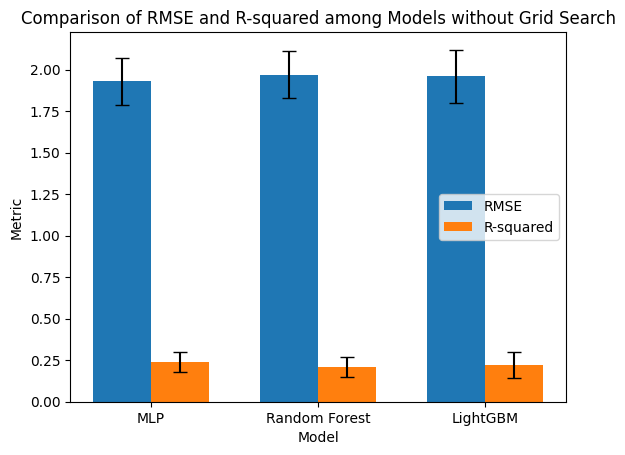

In [ ]:
width = 0.35  # Width of the bars
x = np.arange(len(models))

fig, ax = plt.subplots()
ax.bar(x - width/2, rmse_values, width, yerr=rmse_std, capsize=5, label='RMSE')
ax.bar(x + width/2, r2_values, width, yerr=r2_std, capsize=5, label='R-squared')

ax.set_xlabel('Model')
ax.set_ylabel('Metric')
ax.set_title('Comparison of RMSE and R-squared among Models without Grid Search')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


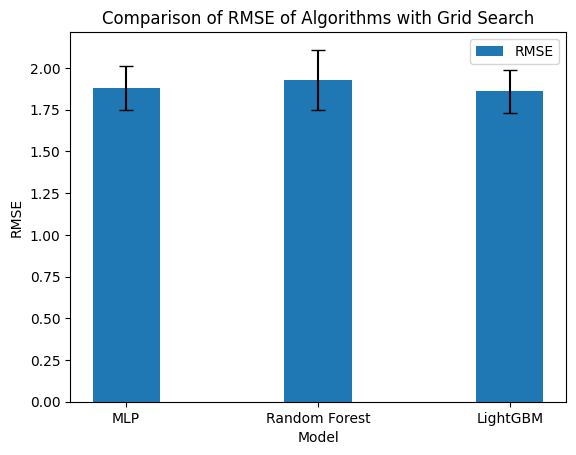

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.35  # Width of the bars
x = np.arange(len(models))

fig, ax = plt.subplots()
ax.bar(x, rmse_values, width, yerr=rmse_std, capsize=5, label='RMSE')

ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE of Algorithms with Grid Search')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


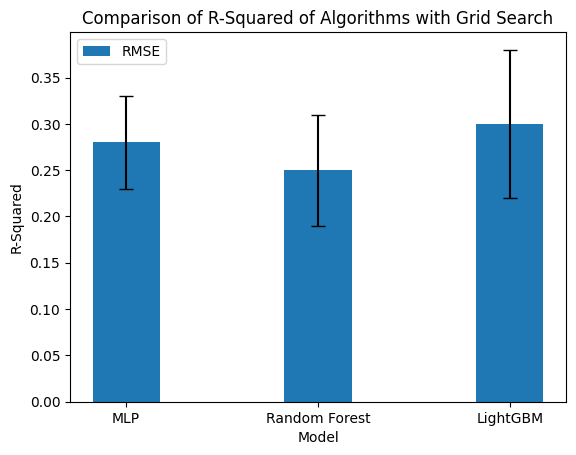

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.35  # Width of the bars
x = np.arange(len(models))

fig, ax = plt.subplots()
ax.bar(x, r2_values, width, yerr=r2_std, capsize=5, label='RMSE')

ax.set_xlabel('Model')
ax.set_ylabel('R-Squared')
ax.set_title('Comparison of R-Squared of Algorithms with Grid Search')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()
